In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jpx-tokyo-stock-exchange-prediction/stock_list.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/options.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/financials.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/secondary_stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/trades.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/__init__.py
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_fin_spec.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/trades_spec.csv
/kaggle/input/jpx-tokyo-stock-

In [2]:
import os
import gc
import copy
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import display_html
#configuration
warnings.simplefilter('ignore')
pd.set_option('max_column', None)
sns.set_style('darkgrid')
colors = sns.color_palette('Set2')

In [3]:
def prep_prices(price):
    
    from decimal import ROUND_HALF_UP, Decimal
    
    pcols = ["Open","High","Low","Close"]

    price["ExpectedDividend"].fillna(0,inplace=True)
    
    def qround(x):
        return float(Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP))
    
    def adjust_prices(df):
        df = df.sort_values("Date", ascending=False)
        df.loc[:, "CumAdjust"] = df["AdjustmentFactor"].cumprod()

        # generate adjusted prices
        for p in pcols:     
            df.loc[:, p] = (df["CumAdjust"] * df[p]).apply(qround)
        df.loc[:, "Volume"] = df["Volume"] / df["CumAdjust"]
        df.ffill(inplace=True)
        df.bfill(inplace=True)
        
        # generate and fill Targets
        #df.loc[:, "Target"] = df.Close.pct_change().shift(-2).fillna(df.Target).fillna(0)
        df.Target.fillna(0,inplace=True)

        return df

    # generate Adjusted
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(adjust_prices).reset_index(drop=True)
    price = price.sort_values("RowId")
    return price

In [4]:
%%time
df_train = pd.read_csv(os.path.join("../input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv"))
df_train = prep_prices(df_train)
stock_list = pd.read_csv(os.path.join("../input/jpx-tokyo-stock-exchange-prediction/stock_list.csv")) # not used
df_test = pd.read_csv(os.path.join("../input/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv"))
df_test = prep_prices(df_test)


CPU times: user 1min 18s, sys: 1.68 s, total: 1min 20s
Wall time: 1min 22s


In [5]:
# make a list of the dataframes of each stock, last dataframe is the train data for model    
list_each_price = []
list_each_stock = []    
for i in df_test['SecuritiesCode'].unique():     
    TRAIN = df_train[df_train.SecuritiesCode==i]
    TEST = df_test[df_test.SecuritiesCode==i]
    df_stock = pd.concat([TRAIN,TEST])
    df_price = df_stock['Close'] # this include the whole time data from 20170104 to 20220624
    df_price.fillna(0,inplace = True)
    list_each_stock.append(df_stock)
    list_each_price.append(df_price)
print ((list_each_stock[0]))

              RowId        Date  SecuritiesCode    Open    High     Low  \
1201  20170104_1301  2017-01-04            1301  2734.0  2755.0  2730.0   
1200  20170105_1301  2017-01-05            1301  2743.0  2747.0  2735.0   
1199  20170106_1301  2017-01-06            1301  2734.0  2744.0  2720.0   
1198  20170110_1301  2017-01-10            1301  2745.0  2754.0  2735.0   
1197  20170111_1301  2017-01-11            1301  2748.0  2752.0  2737.0   
...             ...         ...             ...     ...     ...     ...   
4     20220620_1301  2022-06-20            1301  3400.0  3410.0  3320.0   
3     20220621_1301  2022-06-21            1301  3325.0  3385.0  3315.0   
2     20220622_1301  2022-06-22            1301  3365.0  3435.0  3365.0   
1     20220623_1301  2022-06-23            1301  3460.0  3470.0  3440.0   
0     20220624_1301  2022-06-24            1301  3470.0  3470.0  3385.0   

       Close   Volume  AdjustmentFactor  ExpectedDividend  SupervisionFlag  \
1201  2742.0  31400.0

In [6]:
# standize all the stock price for lstm model
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
list_each_scaled = []
for i in list_each_price:    
    i = scaler.fit_transform(np.array(i).reshape(-1,1))
    list_each_scaled.append(i)

print(list_each_scaled[-1])
print(len(list_each_scaled[0]))

[[0.34201077]
 [0.36355476]
 [0.36894075]
 ...
 [0.27827648]
 [0.27827648]
 [0.28904847]]
1337


In [7]:
# function to create the training X, y data for lstm model
def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step):
        a = dataset[i:(i+time_step), 0] # eg. first x in the dataX = [0:100, 0], second [1:101, 0]... model need this
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0]) # eg. first y in dataY = [100,0], second[101,0]... 
    return np.array(dataX), np.array(dataY)


In [8]:
time_step = 1
X_pred = []
y_pred = []
for i in list_each_scaled:
    x_lstm_pred, y_lstm_pred = create_dataset(i, time_step)
    x_lstm_pred = x_lstm_pred.reshape(x_lstm_pred.shape[0],x_lstm_pred.shape[1] , 1)
    X_pred.append(x_lstm_pred)
    y_pred.append(y_lstm_pred)
print(X_pred[1999].shape,y_pred[1999].shape)
#print(X_pred[1999],y_pred[1999])

(1336, 1, 1) (1336,)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.layers import Dropout
from tensorflow import keras

In [10]:
# build the model 
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(50,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error',optimizer=opt)
# feed the data to the model
#model.fit(X_train,y_train,epochs=50,batch_size=32)
#model.fit(X_Test[1999],y_Test[1999],epochs=5,batch_size=32)
model.fit(X_pred[10],y_pred[10],epochs=30,batch_size=32)

2022-07-06 00:38:00.954818: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-07-06 00:38:01.844545: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
42/42 [==============================] - 7s 6ms/step - loss: 0.1736
Epoch 2/30
42/42 [==============================] - 0s 6ms/step - loss: 0.0244
Epoch 3/30
42/42 [==============================] - 0s 7ms/step - loss: 0.0128
Epoch 4/30
42/42 [==============================] - 0s 6ms/step - loss: 0.0039
Epoch 5/30
42/42 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 6/30
42/42 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 7/30
42/42 [==============================] - 0s 6ms/step - loss: 9.4312e-04
Epoch 8/30
42/42 [==============================] - 0s 6ms/step - loss: 8.3301e-04
Epoch 9/30
42/42 [==============================] - 0s 6ms/step - loss: 7.1386e-04
Epoch 10/30
42/42 [==============================] - 0s 6ms/step - loss: 6.0696e-04
Epoch 11/30
42/42 [==============================] - 0s 6ms/step - loss: 5.2233e-04
Epoch 12/30
42/42 [==============================] - 0s 6ms/step - loss: 4.4671e-04
Epoch 13/30
42/42 [======

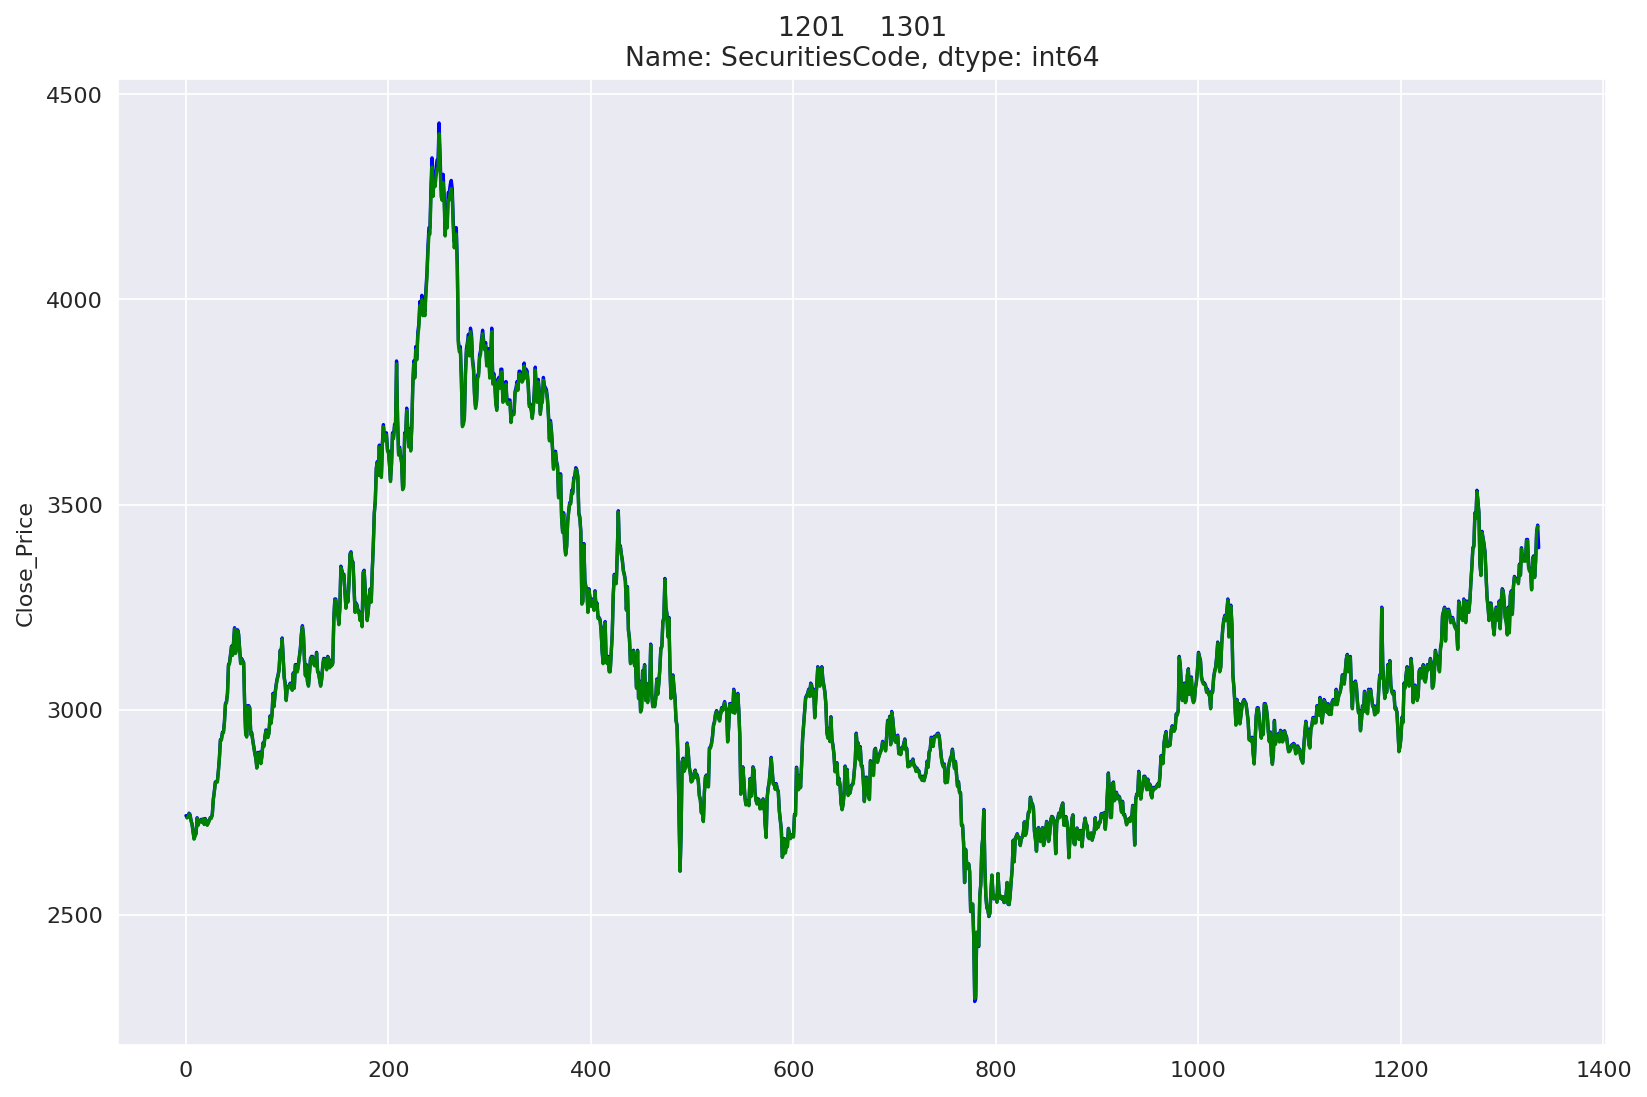

[[2740.2097]
 [2736.2393]
 [2738.2246]
 ...
 [3361.9426]
 [3431.7349]
 [3446.6775]]
CPU times: user 5min 30s, sys: 44.5 s, total: 6min 14s
Wall time: 4min 28s


In [11]:
%%time
# import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

list_pred = [] # list of train prediction for every stock
for i in range(2000):
    pred_one=model.predict(X_pred[i]) 
    
    scaler=MinMaxScaler(feature_range=(0,1)) # construct a scaler of range value 0 to 1
    scaler.fit_transform(np.array(list_each_price[i]).reshape(-1,1)) # train the scaler with each stock value
    pred_unscaled=scaler.inverse_transform(pred_one) # use trained scaler to do the value reverse back to origin value
    list_pred.append(pred_unscaled) # append prediction value of every stock to a list

    # a sample plot of stock # 1999 (start from 0)
    if i ==0 :  
        x_test = range(1,len(list_each_scaled[i])-1)
        figure(figsize=(12, 8), dpi=160)
        plt.title(str(list_each_stock[i][0:1]['SecuritiesCode']), fontdict=None, loc='center', pad=None)
        plt.plot(range(len(list_each_price[i])),list_each_price[i],'b')
        #plt.plot(x_train,train_predict,'orange')
        plt.plot(x_test,pred_unscaled[1:],'g')
        plt.ylabel('Close_Price')
        plt.show()
        print(pred_unscaled)
              
list_pred_copy=copy.deepcopy(list_pred)  

In [12]:
print(list_pred_copy[0])
print(len(list_pred_copy[0]))

[[2740.2097]
 [2736.2393]
 [2738.2246]
 ...
 [3361.9426]
 [3431.7349]
 [3446.6775]]
1336


In [13]:
print(list_pred[0])
print(len(list_pred[0]))

[[2740.2097]
 [2736.2393]
 [2738.2246]
 ...
 [3361.9426]
 [3431.7349]
 [3446.6775]]
1336


In [14]:
#list_pred_copy

In [15]:
list_pred=list_pred_copy
counter = 0
for i in list_each_stock:
    #print(len(i))
    list_pred[counter] = np.insert(list_pred[counter],0,None,axis = 0)
    #X = np.insert(X, 0, 6., axis=0)
    #print(list_pred[counter])
    #print(len(list_train_Predicted_df[counter]))
    #i['Target'] = None
    i['Prediction']=list_pred[counter]
    counter = counter + 1
print(list_each_stock[0])

              RowId        Date  SecuritiesCode    Open    High     Low  \
1201  20170104_1301  2017-01-04            1301  2734.0  2755.0  2730.0   
1200  20170105_1301  2017-01-05            1301  2743.0  2747.0  2735.0   
1199  20170106_1301  2017-01-06            1301  2734.0  2744.0  2720.0   
1198  20170110_1301  2017-01-10            1301  2745.0  2754.0  2735.0   
1197  20170111_1301  2017-01-11            1301  2748.0  2752.0  2737.0   
...             ...         ...             ...     ...     ...     ...   
4     20220620_1301  2022-06-20            1301  3400.0  3410.0  3320.0   
3     20220621_1301  2022-06-21            1301  3325.0  3385.0  3315.0   
2     20220622_1301  2022-06-22            1301  3365.0  3435.0  3365.0   
1     20220623_1301  2022-06-23            1301  3460.0  3470.0  3440.0   
0     20220624_1301  2022-06-24            1301  3470.0  3470.0  3385.0   

       Close   Volume  AdjustmentFactor  ExpectedDividend  SupervisionFlag  \
1201  2742.0  31400.0

In [16]:
%%time
# calculate the r based on predicted column, then make a rt list of all the r values of every stock
for i in range(len(list_each_stock)):
    trgt = []
    for j in range (len(list_each_stock[i])-2): # based on formula, no r values on j day for last two days
        trgt.append((list_each_stock[i]['Prediction'].iloc[j+2]-list_each_stock[i]['Prediction'].iloc[j+1])/list_each_stock[i]['Prediction'].iloc[j+1])
    trgt.append(None)
    trgt.append(None)
    list_each_stock[i]['Target'] = trgt

CPU times: user 1min 39s, sys: 0 ns, total: 1min 39s
Wall time: 1min 39s


In [17]:
df_data = pd.concat(list_each_stock, sort= False)
df_data = df_data.dropna()
print(df_data)

                RowId        Date  SecuritiesCode    Open    High     Low  \
1200    20170105_1301  2017-01-05            1301  2743.0  2747.0  2735.0   
1199    20170106_1301  2017-01-06            1301  2734.0  2744.0  2720.0   
1198    20170110_1301  2017-01-10            1301  2745.0  2754.0  2735.0   
1197    20170111_1301  2017-01-11            1301  2748.0  2752.0  2737.0   
1196    20170112_1301  2017-01-12            1301  2745.0  2747.0  2703.0   
...               ...         ...             ...     ...     ...     ...   
269752  20220616_9997  2022-06-16            9997   693.0   704.0   688.0   
269751  20220617_9997  2022-06-17            9997   682.0   694.0   680.0   
269750  20220620_9997  2022-06-20            9997   693.0   697.0   683.0   
269749  20220621_9997  2022-06-21            9997   692.0   709.0   692.0   
269748  20220622_9997  2022-06-22            9997   706.0   716.0   703.0   

         Close    Volume  AdjustmentFactor  ExpectedDividend  SupervisionFl

In [18]:
%%time
df_TRG= df_data.groupby('Date')['Target'].apply(list) # make a list of Target by every date
df_SC = df_data.groupby('Date')['SecuritiesCode'].apply(list) # make a list of SecuritiesCodes by every date
df_Date = df_data.groupby('Date')['Date'].apply(list) # make a list of dates by every date

#print(df_TRG.astype)
#print(df_SC)
#print(df_Date)
df_tr = pd.DataFrame()
# construct a data frame by combining the records from above dataframe then sort by the Target values, finally arregate
# all of dataframe as the list_rank as the data for submission file

for j in range(len(list_each_stock[0]['Date'])-3):# get rid of first and last two dates without target value
    df_date = pd.DataFrame({'Date':df_Date[j],
                            'SecuritiesCode':df_SC[j],
                            'Target':df_TRG[j]})
    df_date = df_date.sort_values(by = 'Target',ascending = False)
    df_tr=pd.concat([df_tr,df_date])# get rid of last two dates without predictions

print(df_tr)

            Date  SecuritiesCode    Target
457   2017-01-05            3825  0.167436
1000  2017-01-05            6425  0.104672
1297  2017-01-05            7600  0.103995
404   2017-01-05            3547  0.093704
1695  2017-01-05            9233  0.090794
...          ...             ...       ...
1188  2022-06-22            6787 -0.062328
626   2022-06-22            4401 -0.067093
568   2022-06-22            4168 -0.067097
1809  2022-06-22            9115 -0.082656
569   2022-06-22            4169 -0.110876

[2596412 rows x 3 columns]
CPU times: user 31 s, sys: 4.86 s, total: 35.8 s
Wall time: 35.9 s


In [19]:
df_tr1=df_tr.loc[df_tr['Date']==('2021-12-06')]
df_tr2=df_tr.loc[df_tr['Date']==('2021-12-07')]
df_tr = pd.concat([df_tr1,df_tr2])
df_tr

,Date,SecuritiesCode,Target
739,2021-12-06,4699,0.188264
56,2021-12-06,1873,0.186462
1190,2021-12-06,6779,0.155578
1466,2021-12-06,7809,0.133145
305,2021-12-06,3031,0.119131
...,...,...,...
1807,2021-12-07,9090,-0.039091
56,2021-12-07,1873,-0.055706
170,2021-12-07,2329,-0.055873
571,2021-12-07,4169,-0.056085


In [20]:
# for testing purpose
#print(df_rank.loc[df_rank.Target.isnull()])
def add_rank(df, col_name="pred"):
    df["Rank"] = df.groupby("Date")[col_name].rank(ascending=False, method="first") - 1 
    df["Rank"] = df["Rank"].astype("int")
    return df
df_tr_rank = add_rank(df_tr, "Target")
print(df_tr_rank)

            Date  SecuritiesCode    Target  Rank
739   2021-12-06            4699  0.188264     0
56    2021-12-06            1873  0.186462     1
1190  2021-12-06            6779  0.155578     2
1466  2021-12-06            7809  0.133145     3
305   2021-12-06            3031  0.119131     4
...          ...             ...       ...   ...
1807  2021-12-07            9090 -0.039091  1995
56    2021-12-07            1873 -0.055706  1996
170   2021-12-07            2329 -0.055873  1997
571   2021-12-07            4169 -0.056085  1998
300   2021-12-07            2987 -0.072871  1999

[4000 rows x 4 columns]


In [21]:
#df_tr_rank = df_tr_rank.drop(['Target'],axis=1)

In [22]:
df_tr_rank.rename(columns = {'SecuritiesCode':'Securities'}, inplace = True)
#df_tr_rank.to_csv('/kaggle/working/submission1.csv', sep=',', encoding='utf-8',index=False)

In [23]:
def calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    weights_mean = weights.mean()
    #df = df.sort_values(by='Rank')
    purchase = (df['Target'][:portfolio_size]  * weights).sum() / weights_mean
    short    = (df['Target'][-portfolio_size:] * weights[::-1]).sum() / weights_mean
    return purchase - short

#  not used??
def calc_spread_return_sharpe(df, portfolio_size=200, toprank_weight_ratio=2): 
    grp = df.groupby('Date')
    min_size = grp["Target"].count().min()
    if min_size<2*portfolio_size:
        portfolio_size=min_size//2
        if portfolio_size<1:
            return 0, None
    buf = grp.apply(calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio, buf

def add_rank(df, col_name="pred"):
    df["Rank"] = df.groupby("Date")[col_name].rank(ascending=False, method="first") - 1 
    df["Rank"] = df["Rank"].astype("int")
    return df

In [24]:
score = calc_spread_return_per_day(df_tr_rank,200,2)

In [25]:
def pred_codes(cod, tr):
    tr = tr[tr.SecuritiesCode==cod][["Date","Close"]]
    x = [0,1]
    for _ in x:
        tr = tr.append(
        pd.DataFrame({'Date': pd.date_range(start=tr.Date.iloc[-1], 
                                            periods=2, freq='B', 
                                            closed='right'),
                      'Close': np.poly1d(np.polyfit(x,tr.Close[-2:],1))(2)
                     })
        )
    #print('tr in function:', tr['Date'])
    tr = add_feat(tr)
    tr = tr[6:]
    target = run_reg(tr)
    return target

In [26]:
import jpx_tokyo_market_prediction
env = jpx_tokyo_market_prediction.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test files
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    tr = df_tr_rank[df_tr_rank.Date==prices.Date.iat[0]].copy()
    score = calc_spread_return_per_day(tr,200,2)
    print(f"Score: {score}")
    #df_tr_rank['Rank'] = np.arange(len(df_tr_rank))  # make your predictions here
    sample_pred= tr[['Date','Securities','Rank']]
    sample_pred.sort_values(['Date', 'Securities'], ascending=[True, True])
    #df_tr_rank.to_csv('/kaggle/working/submission2.csv')
    env.predict(sample_pred)   # register your predictions

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
Score: 14.256938487538694
Score: 13.553533374951211


In [27]:
#import shutil

In [28]:
#my_data = pd.read_csv(kaggle/working/submission.csv')

In [29]:
#shutil.copyfile('../kaggle/working/submission.csv', 'D:\Google Drive 1\Data Science\Online_Competition\submission.csv')